# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.389830
sanity check: 2.302585


In [4]:
loss = 0
scores = X_dev.dot(W)
p = np.exp(scores) / np.sum(np.exp(scores),axis = 1, keepdims = True)
cp = np.choose(y_dev,p.T).reshape(500,1)
ds = p
ds[range(0,500),y_dev] -= 1
ds /= 500
dW = np.dot(X_dev.T, ds)
print (dW[0])
0.000005 *2* W [0]

[-0.69134937  3.34443162  0.25351074 -1.61377417  3.27484915  1.45628859
  2.18746048  0.71535826 -3.97971292 -4.94706239]


array([ -3.76847808e-11,  -5.29842094e-10,  -3.68453705e-10,
         1.63842864e-09,  -1.53228392e-09,  -2.94486540e-10,
        -3.00298090e-10,   5.93062242e-10,   3.90931645e-10,
        -8.67440087e-10])

In [5]:
scores = np.dot(X_dev, W)
  
  # compute the class probabilities
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
# compute the gradient on scores
dscores = probs
dscores[range(500),y_dev] -= 1
dscores /= 500
  
# backpropate the gradient to the parameters (W,b)
dW = np.dot(X_dev.T, dscores)
dW += 0.00005 * W
print(dW[0])
dW[0]

[-0.69134937  3.34443162  0.25351074 -1.61377416  3.27484914  1.45628859
  2.18746048  0.71535826 -3.97971291 -4.9470624 ]


array([-0.69134937,  3.34443162,  0.25351074, -1.61377416,  3.27484914,
        1.45628859,  2.18746048,  0.71535826, -3.97971291, -4.9470624 ])

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
#loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.298245 analytic: 1.298245, relative error: 8.518767e-09
numerical: -2.290444 analytic: -2.290444, relative error: 1.451964e-08
numerical: -0.314503 analytic: -0.314503, relative error: 1.002532e-08
numerical: -1.314595 analytic: -1.314595, relative error: 4.514787e-08
numerical: 1.723582 analytic: 1.723582, relative error: 4.139962e-08
numerical: -1.749773 analytic: -1.749773, relative error: 1.489552e-08
numerical: -2.417959 analytic: -2.417959, relative error: 1.709886e-08
numerical: 5.792400 analytic: 5.792400, relative error: 1.583382e-08
numerical: -1.200697 analytic: -1.200697, relative error: 3.516638e-08
numerical: 1.932789 analytic: 1.932789, relative error: 4.592581e-08
numerical: 3.117910 analytic: 3.117910, relative error: 2.042892e-08
numerical: 5.269775 analytic: 5.269775, relative error: 9.127121e-09
numerical: 2.147194 analytic: 2.147194, relative error: 3.031134e-08
numerical: -0.356366 analytic: -0.356366, relative error: 1.007590e-07
numerical: 1.299773 

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.389830e+00 computed in 0.190085s
vectorized loss: 2.389830e+00 computed in 0.015627s
Loss difference: 0.000000
Gradient difference: 0.000000


In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in (np.random.uniform(learning_rates[0], learning_rates[1],10)):
    for reg in (np.random.uniform(regularization_strengths[0], regularization_strengths[1],10)):
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred) 
        y_val_pred = softmax.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
            print ("best_va: %f" %best_val)
            
        print ("learning rate: %f" %lr)
        print ("reg: %f" %reg)
        print ("val accuracy: %f" %validation_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best_va: 0.318000
learning rate: 0.000000
reg: 36876.950768
val accuracy: 0.318000
learning rate: 0.000000
reg: 37955.225185
val accuracy: 0.314000
learning rate: 0.000000
reg: 41283.172312
val accuracy: 0.311000
learning rate: 0.000000
reg: 40249.437943
val accuracy: 0.314000
best_va: 0.323000
learning rate: 0.000000
reg: 35842.680219
val accuracy: 0.323000
learning rate: 0.000000
reg: 34037.472003
val accuracy: 0.320000
learning rate: 0.000000
reg: 31956.693654
val accuracy: 0.316000
learning rate: 0.000000
reg: 40445.601180
val accuracy: 0.317000
learning rate: 0.000000
reg: 44726.531942
val accuracy: 0.311000
learning rate: 0.000000
reg: 48187.161173
val accuracy: 0.306000
learning rate: 0.000000
reg: 42420.319154
val accuracy: 0.304000
learning rate: 0.000000
reg: 38821.246519
val accuracy: 0.319000
learning rate: 0.000000
reg: 42690.160752
val accuracy: 0.315000
learning rate: 0.000000
reg: 41573.226324
val accuracy: 0.317000
learning rate: 0.000000
reg: 47140.292031
val accuracy

In [44]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.324000


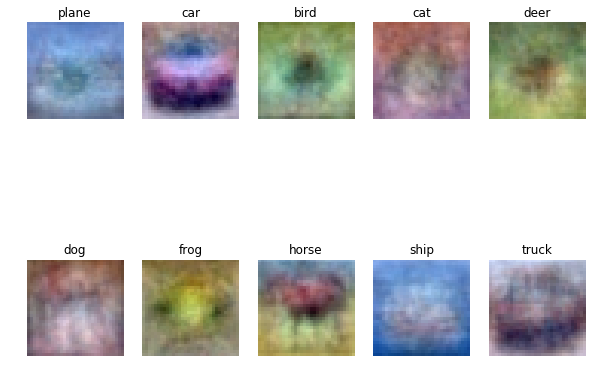

In [45]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])